In [1]:
import pandas as pd
import matplotlib.pyplot as plt  
from datetime import datetime   #数据索引改为时间
from pandas import datetime
import numpy as np
import statsmodels.api as sm     #acf,pacf图
from statsmodels.tsa.stattools import adfuller  #adf检验
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA  


C:\Users\Maggie\AppData\Local\Temp\ipykernel_15736\1161333456.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
data = pd.read_csv('C_DATA\BTC-USD.csv', header=0, parse_dates=['Date'],index_col='Date')
data = pd.DataFrame(data,dtype=np.float64)
price = data['Price']
data

,Price
Date,
2014-09-17,468.174011
2014-09-18,456.859985
2014-09-19,427.834991
2014-09-20,423.295990
2014-09-21,412.425995
...,...
2016-09-05,609.054993
2016-09-06,610.830017
2016-09-07,614.544983


In [3]:
ret = price.diff(1)/price
data.fillna(method='backfill',inplace=True)
data = data.drop(columns='Price')
data['r2'] = np.array(ret)**2
data.fillna(method='backfill',inplace=True)
data

,r2
Date,
2014-09-17,0.000613
2014-09-18,0.000613
2014-09-19,0.004602
2014-09-20,0.000115
2014-09-21,0.000695
...,...
2016-09-05,0.000021
2016-09-06,0.000008
2016-09-07,0.000037


In [4]:
r2 = data['r2'].values
t = adfuller(r2)  # ADF检验
output=pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used","Critical Value(1%)","Critical Value(5%)","Critical Value(10%)"],columns=['value'])
output['value']['Test Statistic Value'] = t[0]
output['value']['p-value'] = t[1]
output['value']['Lags Used'] = t[2]
output['value']['Number of Observations Used'] = t[3]
output['value']['Critical Value(1%)'] = t[4]['1%']
output['value']['Critical Value(5%)'] = t[4]['5%']
output['value']['Critical Value(10%)'] = t[4]['10%']
output


,value
Test Statistic Value,-5.301169
p-value,0.000005
Lags Used,15
Number of Observations Used,708
Critical Value(1%),-3.43962
Critical Value(5%),-2.865631
Critical Value(10%),-2.568948


In [5]:
# 白噪声检验（如果是白噪声，即纯随机序列，则没有研究的意义了。）
from statsmodels.stats.diagnostic import acorr_ljungbox
print(acorr_ljungbox(r2, lags=1)) 

     lb_stat     lb_pvalue
1  46.239347  1.046541e-11


In [6]:
# train = data[['Date','return']]
# train.set_index('Date')
train = r2


In [7]:
# (p,q)=sm.tsa.arma_order_select_ic(train,max_ar=6,max_ma=4,ic='aic')['aic_min_order']

In [8]:
model = ARIMA(train, order=(4,0,4)).fit()
model.summary()        #生成一份模型报告


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  724
Model:                 ARIMA(4, 0, 4)   Log Likelihood                3213.994
Date:                Sun, 20 Feb 2022   AIC                          -6407.988
Time:                        16:19:55   BIC                          -6362.140
Sample:                             0   HQIC                         -6390.292
                                - 724                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      2.476      0.013       0.000       0.002
ar.L1          0.6381      0.899      0.709      0.478      -1.125       2.401
ar.L2          0.2427      1.110      0.219      0.827      -1.932       2.418
ar.L3         -0.0117      1.093     -0.011      0.991      -2.154       2.131
ar.L4         -0.0237      0.527     -0.045      0.964      -1.056       1.008
ma.L1         -0.4254      0.898     -0.474      0.636      -2.185       1.334
ma.L2         -0.2138      1.004     -0.213      0.831      -2.182       1.754
ma.L3         -0.0249      0.954     -0.026      0.979      -1.896       1.846
ma.L4         -0.0641      0.373     -0.172      0.863      -0.795       0.666
sigma2      8.157e-06   1.37e-07     59.542      0.000    7.89e-06    8.43e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            144548.63
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.20   Skew:                             6.75
Prob(H) (two-sided):                  0.00   Kurtosis:                        70.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.23e+14. Standard errors may be unstable.
"""

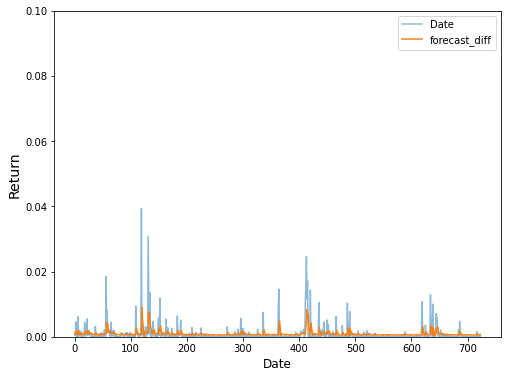

In [9]:
predictions_ARIMA_diff = pd.Series(model.fittedvalues, copy=True)
# print(predictions_ARIMA_diff.head())

plt.figure(figsize=(8,6))
plt.plot(r2,label="Date",alpha=0.5)
plt.plot(predictions_ARIMA_diff,label="forecast_diff")
plt.ylim(0,0.1)
plt.xlabel('Date',fontsize=12,verticalalignment='top')
plt.ylabel('Return',fontsize=14,horizontalalignment='center')
plt.legend()
plt.show()